# Problem 1

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from astropy import units as u
from astropy import constants as c

Expanding eq. 1 with product rule, we obtain
$$
\frac{1}{x^2} \frac{d}{dx} \Big( x^2 \frac{dy}{dx} \Big) = e^{-y} \\
\frac{1}{x^2} \Big( 2x \frac{dy}{dx} + x^2 \frac{d^2y}{dx^2} \Big) = e^{-y} \\
\frac{d^2y}{dx^2} + \frac{2}{x} \frac{dy}{dx} - e^{-y} = 0.
$$
The function solve_ivp() can't solve 2nd order ODEs, but this equation can be split into two 1st order ODEs. Let $y' = \frac{dy}{dx}$ and $u = y'$. Our two equations are now
$$
y' = u \\
u' = e^{-y} - \frac{2}{x}u
$$
which can be solved with the initial condition $x=0, y=0, u=0$. The Runge-Kutta method is the default method used by solve_ivp() to integrate the differential equations. The Runge-Kutta method is similar to Euler's method except that it obtains a better approximation of the slope at each step. Refer to https://www.haroldserrano.com/blog/visualizing-the-runge-kutta-method for more information.

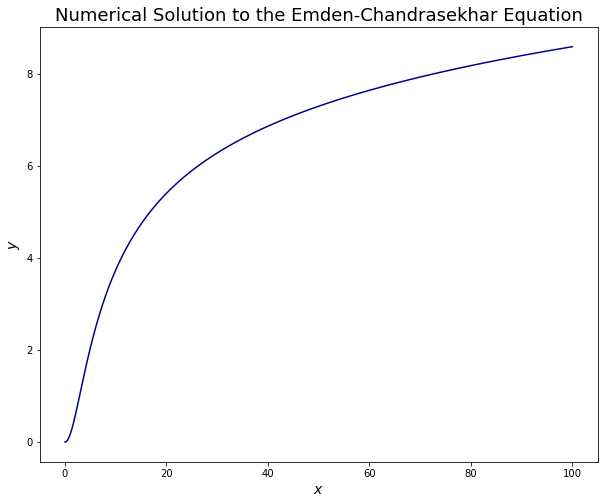

In [36]:
def dAdx(x, A):
    """
    Returns dA/dx = [y', u'] = [u, e^-y - 2u/x], which is our set of ODEs.
    
    PARAMETERS
    A: A = [y, u]
    x: x
    """
    y, u = A
    return [u, np.exp(-y) - 2*u/x]

y0 = 0
u0 = 0
A0 = [y0, u0]


xspan = (1e-4, 100)
nx = 10000
xrange = np.logspace(np.log10(xspan[0]), np.log10(xspan[1]), nx)

sol = solve_ivp(dAdx, t_span=xspan, y0=A0, t_eval=xrange, method='RK45')

plt.figure(figsize=(10,8))
plt.plot(sol.t, sol.y[0], c='darkblue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title('Numerical Solution to the Emden-Chandrasekhar Equation', fontsize=18)
plt.show()

# Problem 2

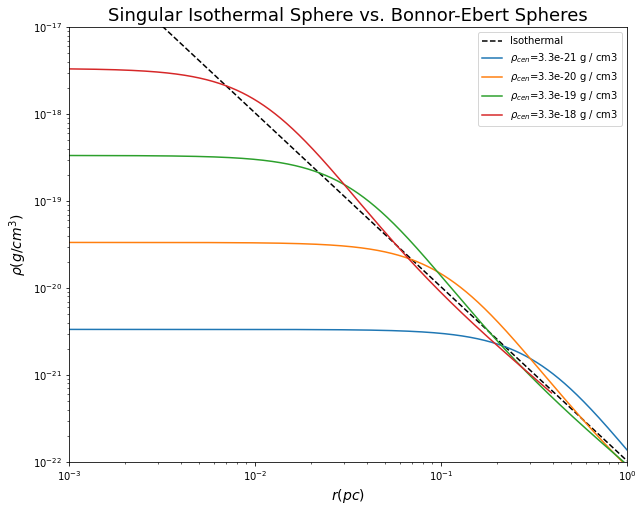

In [37]:
n_cen = [1e3, 1e4, 1e5, 1e6] * u.cm**-3
rho_cen = n_cen * (2*u.M_p).cgs
T = 10 * u.K
const = np.sqrt(c.k_B*T/(2*u.M_p))

fig = plt.figure(figsize=(10,8))
for i in range(4):
    r = (np.sqrt(const**2/(4*np.pi*c.G*rho_cen[i])) * sol.t).to(u.pc)
    rho_EC = rho_cen[i] * np.exp(-1*sol.y[0])
    if i == 0:
        rho_iso = (const**2/(2*np.pi*c.G*r**2)).cgs.value
        plt.plot(r, rho_iso, 'k--', label='Isothermal')
    plt.plot(r, rho_EC, label=r'$\rho_{cen}$=' + '{:.1e}'.format(rho_cen[i]))
    
plt.xlabel(r'$r (pc)$', fontsize=14)
plt.ylabel(r'$\rho (g/cm^3)$', fontsize=14)
plt.title('Singular Isothermal Sphere vs. Bonnor-Ebert Spheres', fontsize=18)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-3, 1])
plt.ylim([1e-22, 1e-17])
plt.legend()
plt.show()

# Problem 3

Define the following variables:

$$
\begin{align}
\rho_{amb} & = \rho_{cen} e^{-\psi/c^2} \\
y & = \frac{\psi}{c^2} = \log \Big( \frac{\rho_{cen}}{\rho_{amb}} \Big) \\
r & = \Big( \frac{c^2}{4 \pi G \rho_{cen}}\Big)^{1/2} x \\
dr & = \Big( \frac{c^2}{4 \pi G \rho_{cen}}\Big)^{1/2} x .
\end{align}
$$
The Bonnor-Ebert mass can then be found by integrating the density and substituting in the above variables.
$$
\begin{align}
M_{BE} & = \int_0^{r_{amb}} 4 \pi r^2 \rho(r) dr\\
& = 4 \pi \rho_{cen} \Big( \frac{c^2}{4 \pi G \rho_{cen}}\Big)^{3/2} \int_0^{x_{amb}} x^2 e^{-y} dx \\
& = \Big(\frac{\rho_{amb}}{\rho_{amb}} \Big)^{1/2} \times \frac{c^3}{(4 \pi G \rho_{cen})^{1/2}} \int_0^{x_{amb}} x^2 e^{-y} dx \\
& =  \frac{c^3}{(4 \pi G \rho_{amb})^{1/2}} \Big[ \Big( \frac{\rho_{cen}}{\rho_{amb}} \Big)^{-1/2} \int_0^{x_{amb}} x^2 e^{-y} dx \Big]
\end{align}
$$

Maximum mass: 2.69 M_sun
Contrast: 4.88


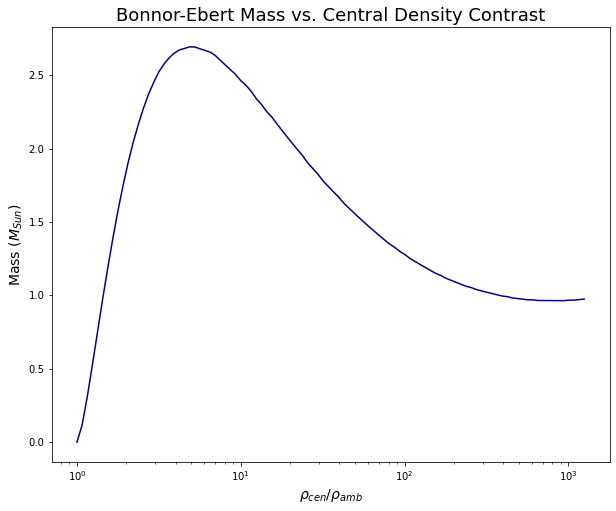

In [74]:
points = 100

# set the ambient density
n_ext = 800 # H2/cm^-3
rho_ext = n_ext * (2*u.M_p/(u.cm**3)).cgs

n0 = np.logspace(np.log10(n_ext), 6, points)
mass = np.zeros(points)
rho_ratio = np.zeros(points)
test = np.zeros(points)

for i in range(points):
    rho_ratio[i] = n0[i]/n_ext
    rho0 = n0[i] * (2*u.M_p/(u.cm**3)).cgs
    # meets the boundary condition where it matches n_ext
    rho = rho0.value * np.exp(-1*sol.y[0])
    idx = np.argmin(np.abs(rho - rho_ext.value))
    rho_amb = rho[idx] * u.g/u.cm**3
    x_amb = sol.t[idx]
    # get the ratio and solve for M_BE
    y_xamb = np.log(rho_ratio[i])
    f = lambda x, y: np.exp(-y)*x**2
    integral = quad(f, 0, x_amb, args=y_xamb)[0]
    test[i] = y_xamb
    res = integral * (const**3/np.sqrt(4*np.pi*c.G**3*rho0)/c.M_sun).cgs
    mass[i] = res

j_max = np.argmax(mass)
print('Maximum mass: ' + '{:.2f}'.format(mass[j_max]) + ' M_sun')
print('Contrast: ' + '{:.2f}'.format(rho_ratio[j_max]))

plt.figure(figsize=(10,8))
plt.plot(rho_ratio, mass, c='darkblue')
plt.xlabel(r'$\rho_{cen} / \rho_{amb}$', fontsize=14)
plt.ylabel(r'Mass ($M_{Sun}$)', fontsize=14)
plt.title('Bonnor-Ebert Mass vs. Central Density Contrast', fontsize=18)
plt.xscale('log')
plt.show()